# --- Data Loading and Preprocessing ---

In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

# Function to load images and  labels
def load_data(image_dir, label_file):
    image_data, label_data = [], []
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in tqdm(lines):
        filename, label = line.strip().split('\t')
        image_path = os.path.join(image_dir, filename)
        if os.path.exists(image_path):
            img = io.imread(image_path)
            image_data.append(img)
            label_data.append(int(label))

    return np.array(image_data) / 255.0, np.array(label_data)

X_train, y_train = load_data('train', 'train_class_labels.txt')
X_test, y_test = load_data('test', 'test_class_labels.txt')

100%|██████████| 2000/2000 [00:00<00:00, 3632.58it/s]


# --- check the data visually ---

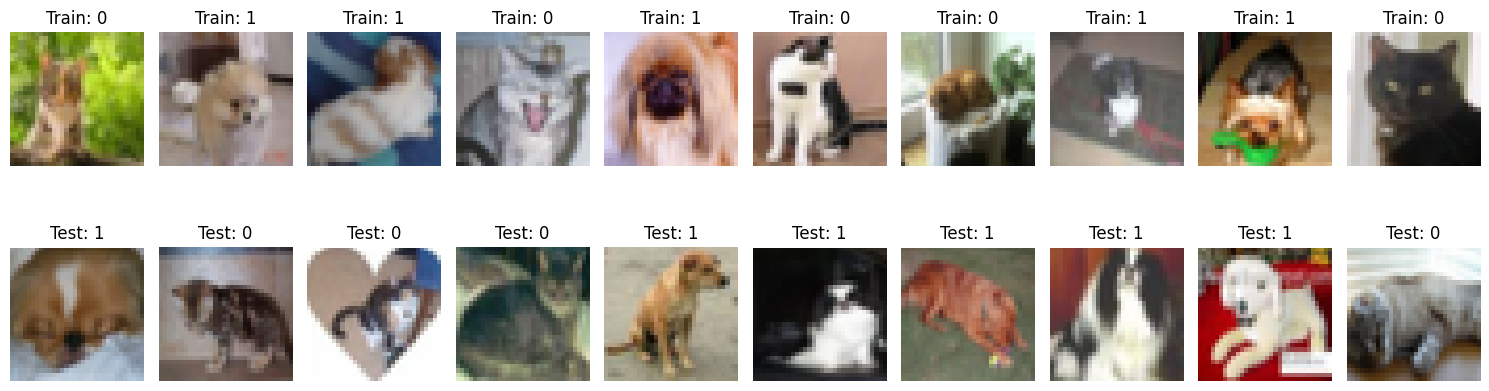

In [11]:
# to inspect the data visually
plt.figure(figsize=(15, 5))
for i in range(10):
    idx = random.randint(0, len(X_train) - 1)
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f'Train: {y_train[idx]}')
    plt.axis('off')
for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(X_test[idx])
    plt.title(f'Test: {y_test[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# --- Define Hyperparameter Search Space ---

In [12]:
''' dictionary to defines the range and type of hyperparameters HyperOpt will search.
All parameters are defined according to the assignment's specified ranges and requirements.'''
space = {
    # Number of CNN layers: between 2 and 4 (categorical choice)
    'n_cnn_layers': hp.choice('n_cnn_layers', [2, 3, 4]),

    # Number of kernels in each CNN layer between 20 and 150, step of 10.
    'cnn_filters_1': hp.quniform('cnn_filters_1', 20, 150, 10),
    'cnn_filters_2': hp.quniform('cnn_filters_2', 20, 150, 10),
    'cnn_filters_3': hp.quniform('cnn_filters_3', 20, 150, 10),
    'cnn_filters_4': hp.quniform('cnn_filters_4', 20, 150, 10),

    # Number of hidden dense layers: between 1 and 3 (categorical choice)
    'n_dense_layers': hp.choice('n_dense_layers', [1, 2, 3]),

    # Nodes in each dense layer: between 10 and 50, step of 10.
    'dense_units_1': hp.quniform('dense_units_1', 10, 50, 10),
    'dense_units_2': hp.quniform('dense_units_2', 10, 50, 10),
    'dense_units_3': hp.quniform('dense_units_3', 10, 50, 10),

    # Dropout rates for CNN layers
    'dropout_cnn1': hp.uniform('dropout_cnn1', 0.2, 0.4), # CNN layers 1 and 2: 20%-40%
    'dropout_cnn2': hp.uniform('dropout_cnn2', 0.2, 0.4),
    'dropout_cnn3': hp.uniform('dropout_cnn3', 0.3, 0.5), # CNN layers 3 and 4: 30%-50%
    'dropout_cnn4': hp.uniform('dropout_cnn4', 0.3, 0.5),

    # Dropout rates for hidden dense layers
    'dropout_dense1': hp.uniform('dropout_dense1', 0.2, 0.4), # Dense layers 1 and 2: 20%-40%
    'dropout_dense2': hp.uniform('dropout_dense2', 0.2, 0.4),
    'dropout_dense3': hp.uniform('dropout_dense3', 0.3, 0.5), # Dense layer 3: 30%-50%
}
# Global variables to store the best accuracy found and the model.
best_accuracy = 0
best_model = None

# --- Objective Function for HyperOpt ---

In [13]:

# function to define CNN model for  hyperparameters.
def objective(params):
    global best_accuracy, best_model # Declare global to update outside function scope

    model = Sequential()

    # Input Layer
    model.add(Input(shape=(32, 32, 3)))

    ''' Hidden 2D CNN Layers
    ReLU activation, (3,3) kernel'''
    model.add(Conv2D(int(params['cnn_filters_1']), (3, 3), activation='relu', padding='same'))
    model.add(Dropout(params['dropout_cnn1']))

    if params['n_cnn_layers'] >= 2:
        model.add(Conv2D(int(params['cnn_filters_2']), (3, 3), activation='relu', padding='same'))
        model.add(Dropout(params['dropout_cnn2']))
    if params['n_cnn_layers'] >= 3:
        model.add(Conv2D(int(params['cnn_filters_3']), (3, 3), activation='relu', padding='same'))
        model.add(Dropout(params['dropout_cnn3']))
    if params['n_cnn_layers'] == 4:
        model.add(Conv2D(int(params['cnn_filters_4']), (3, 3), activation='relu', padding='same'))
        model.add(Dropout(params['dropout_cnn4']))

    # Max Pooling Layer: Applied after all CNN layers Pooling size of (2,2) and stride of 1.
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    model.add(Flatten()) # Flatten the 3D output to 1D for dense layers

    # Hidden Dense Layers RELu activation
    model.add(Dense(int(params['dense_units_1']), activation='relu'))
    model.add(Dropout(params['dropout_dense1']))
    if params['n_dense_layers'] >= 2:
        model.add(Dense(int(params['dense_units_2']), activation='relu'))
        model.add(Dropout(params['dropout_dense2']))
    if params['n_dense_layers'] == 3:
        model.add(Dense(int(params['dense_units_3']), activation='relu'))
        model.add(Dropout(params['dropout_dense3']))

    # Output Layer One node with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model Using Adam optimizer with default learning rate, Binary crossentropy 
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


    # This speeds up training by avoiding unnecessary epochs
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    ''' Train the model:

    epochs=30, 
    batch size =64
    verbose=0 good balance for accuracy and performance'''
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=30,
                        batch_size=64,
                        callbacks=[early_stop],
                        verbose=0)

    # Evaluate the model's performance on the test set.
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Update global best model if current model performs better on the test set.
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model # Store the Keras model object

    # Return negative accuracy as HyperOpt minimizes the objective function.
    return {'loss': -accuracy, 'status': STATUS_OK}

# --- Run Hyperparameter Tuning with HyperOpt ---

In [14]:

trials = Trials() # Stores information about each hyperparameter trial.
best_params = fmin(fn=objective, # The objective function to minimize.
                   space=space,   # The hyperparameter search space.
                   algo=tpe.suggest, # Tree-structured Parzen Estimator algorithm for intelligent search.
                   max_evals=20,  # Run for at least 20 iterations
                   trials=trials) # Pass the Trials object to record results.

# Print the best hyperparameters found by HyperOpt.
print("\nBest Hyperparameters Found:", best_params)


# Evaluate the best_model  on the test set to report its predicted accuracy
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy of Best Model: {accuracy * 100:.2f}%")

100%|██████████| 20/20 [47:41<00:00, 143.05s/trial, best loss: -0.6585000157356262]

Best Hyperparameters Found: {'cnn_filters_1': np.float64(130.0), 'cnn_filters_2': np.float64(100.0), 'cnn_filters_3': np.float64(90.0), 'cnn_filters_4': np.float64(140.0), 'dense_units_1': np.float64(40.0), 'dense_units_2': np.float64(20.0), 'dense_units_3': np.float64(40.0), 'dropout_cnn1': np.float64(0.3269939479602377), 'dropout_cnn2': np.float64(0.3679182407681154), 'dropout_cnn3': np.float64(0.32742922542780695), 'dropout_cnn4': np.float64(0.49281265375614897), 'dropout_dense1': np.float64(0.2720663663297153), 'dropout_dense2': np.float64(0.26000985297118034), 'dropout_dense3': np.float64(0.3918551892), 'n_cnn_layers': np.int64(0), 'n_dense_layers': np.int64(2)}

Final Test Accuracy of Best Model: 65.85%
